# <font color='#A533FF'>Module 1: Business Understanding</font>

AirBnB is an online-platform dedicated to the offer of accommodation to individuals and tourists (vacation rentals) through which hosts can advertise and contract the rental of their properties with their guests. For this project we will explore and analyze the AirBnB data of Valencia (Spain), a city on the shores of the Mediterranean Sea.


#### Project Structure:

The project follow the CRISP-DM Process (Cross Industry Process for Data Mining):

1. Business Understanding.
2. Data Understanding.
3. Data Preparation.
4. Data Modelling.
5. Result Evaluation.
6. Deployment (available on GitHub repository and Medium Blog Post only).



#### Questions to be answered:



- A. What are the busiest times of the year to visit Valencia? By how much do prices spike?

- B. What type of airbnb is the most booked in the city?

- C. How well can we predict the Valencia Airbnb price? What aspects correlate well to the price?

# <font color='#A533FF'>Module 2: Data Understanding</font>

I choose the following datasets, available on http://insideairbnb.com/get-the-data/, to answer the above questions:

- **calendar.csv:** Contains the availability information, prices and minimum/maximum nights of each rental in Valencia between the period of time 2021-06-27 and 2022-06-28.


- **listings.csv:** Contains detailed information about the rooms/houses, the hosts and the rental neighbourhood. During the project, the information of each variable used will be detailed.

### Importing libraries and loading the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import folium.plugins as plugins
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

import warnings
warnings.filterwarnings('ignore')

In [2]:
calendar = pd.read_csv("data/calendar_2021.csv")
listings = pd.read_csv("data/listings.csv")

### Exploring the 'calendar' dataset 

In [3]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,193326,2021-06-28,t,$45.00,$45.00,1.0,1125.0
1,48154,2021-06-28,f,$45.00,$45.00,3.0,25.0
2,48154,2021-06-29,f,$45.00,$45.00,3.0,25.0
3,48154,2021-06-30,f,$45.00,$45.00,3.0,25.0
4,48154,2021-07-01,f,$45.00,$45.00,3.0,25.0


In [4]:
print("The calendar dataset has " + str(calendar.shape[0]) + " rows and " + str(calendar.shape[1]) + " columns.")

The calendar dataset has 1981222 rows and 7 columns.


In [5]:
# Searching all the columns without missing values
no_nulls_calendar = set([calendar.columns[i] for i in range(0,7) if (calendar[(calendar.columns[i])].isna().sum() == 0)])
print(no_nulls_calendar)

{'available', 'listing_id', 'date'}


In [6]:
# Finding columns with more than 50% of their values missing
missing_cols_75_calendar = set(calendar.columns[calendar.isnull().mean() > 0.5])
print(missing_cols_75_calendar)

set()


In [7]:
# Finding columns with more than 2% of their values missing
calendar.columns[calendar.isnull().mean() > 0.02]

Index([], dtype='object')

It is shown that the **% of NaN values is less than 2%** of the total data available, so I proceed to drop the NaN values of this dataset (drop only the rows that contain NaN values for this columns).

In [8]:
calendar_copy = calendar.copy()
calendar_copy = calendar_copy.dropna()
print("The new dataframe has " + str(calendar.shape[0]) + " rows and " + str(calendar.shape[1]) + " columns.")

The new dataframe has 1981222 rows and 7 columns.


In [9]:
calendar_copy.dtypes

listing_id          int64
date               object
available          object
price              object
adjusted_price     object
minimum_nights    float64
maximum_nights    float64
dtype: object

We observe that 'price' and 'adjusted_price' variables are shown as type object. It is needed to transform them to numeric as well as remove the dollar symbol in order to achieve it. We will see this later.

In [10]:
# Let's take a look at the summary statistics associated with the quantitative variables
calendar_copy.describe()

,listing_id,minimum_nights,maximum_nights
count,1.980083e+06,1.980083e+06,1.980083e+06
mean,2.947914e+07,5.461517e+00,8.605985e+02
std,1.443045e+07,1.708751e+01,4.628517e+02
min,4.815400e+04,1.000000e+00,1.000000e+00
25%,1.813103e+07,2.000000e+00,3.650000e+02
50%,2.989972e+07,2.000000e+00,1.125000e+03
75%,4.267263e+07,4.000000e+00,1.125000e+03
max,5.064875e+07,3.650000e+02,1.000000e+04


We can extract from this table that 5,45 nights are the mean of minimum nights and 8,6 the maximum nights available in this dataset for this population.

In [11]:
# Knowing the data period of time:
print("Dates are between " + min(calendar_copy["date"]) + " and " + max(calendar_copy["date"]) + ".")

Dates are between 2021-06-27 and 2022-06-28.


### Exploring the 'listings' dataset 

In [12]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,48154,https://www.airbnb.com/rooms/48154,20211218004345,2021-12-18,beautiful apartment wifi,<b>The space</b><br />Hello everybody and than...,NaN,https://a0.muscache.com/pictures/1109085/9c0d4...,219476,https://www.airbnb.com/users/show/219476,...,4.72,4.44,4.52,VT-41540-V,f,2,2,0,0,0.84
1,55692,https://www.airbnb.com/rooms/55692,20211218004345,2021-12-18,Delight in city center,A great place to stay and visit Valencia.<br /...,NaN,https://a0.muscache.com/pictures/329316/a5d6a7...,120649,https://www.airbnb.com/users/show/120649,...,5.00,5.00,5.00,NaN,f,1,1,0,0,0.01
2,95393,https://www.airbnb.com/rooms/95393,20211218004345,2021-12-18,Modern and bright Duplex 3 Bedrooms Center Wi-Fi,"This is ""Edificio Palomar Apartments"", I will ...",It is just 10 min walking distance to the Cath...,https://a0.muscache.com/pictures/931683/64aebc...,508042,https://www.airbnb.com/users/show/508042,...,4.75,4.75,4.67,31815,f,6,6,0,0,0.80
3,100347,https://www.airbnb.com/rooms/100347,20211218004345,2021-12-18,3BDR full Home at Sorolla station and Metro Jesús,Te va a encantar mi espacio por la ubicación y...,"Barrio de Jesús, cercano al centro, zona conso...",https://a0.muscache.com/pictures/b0bb18e8-1f24...,1451371,https://www.airbnb.com/users/show/1451371,...,4.89,4.80,4.65,NaN,f,1,1,0,0,2.71
4,102524,https://www.airbnb.com/rooms/102524,20211218004345,2021-12-18,EXCLUSIVE VILLA WITH POOL & 5 SUITES ON THE BEACH,DO NOT PARTY OR STAG/HEN PARTIES! THE RESERVAT...,Best restaurantes bars and clubs and chill out...,https://a0.muscache.com/pictures/d2019707-1596...,535881,https://www.airbnb.com/users/show/535881,...,4.61,4.78,4.36,VT-36438-V,f,7,6,1,0,1.19


In [13]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [14]:
print("The listings dataset has " + str(listings.shape[0]) + " rows and " + str(listings.shape[1]) + " columns.")

The listings dataset has 5546 rows and 74 columns.


In [15]:
# Searching all the columns without missing values
no_nulls_listings = set([listings.columns[i] for i in range(0,74) if (listings[(listings.columns[i])].isna().sum() == 0)])
print(no_nulls_listings)

{'host_verifications', 'latitude', 'picture_url', 'calculated_host_listings_count_private_rooms', 'last_scraped', 'name', 'host_id', 'accommodates', 'maximum_nights_avg_ntm', 'minimum_nights_avg_ntm', 'maximum_maximum_nights', 'amenities', 'number_of_reviews_l30d', 'minimum_maximum_nights', 'availability_60', 'calculated_host_listings_count_shared_rooms', 'id', 'number_of_reviews', 'neighbourhood_group_cleansed', 'maximum_minimum_nights', 'room_type', 'minimum_minimum_nights', 'availability_365', 'availability_90', 'number_of_reviews_ltm', 'maximum_nights', 'listing_url', 'calculated_host_listings_count', 'calendar_last_scraped', 'minimum_nights', 'property_type', 'scrape_id', 'instant_bookable', 'calculated_host_listings_count_entire_homes', 'host_url', 'neighbourhood_cleansed', 'price', 'has_availability', 'availability_30', 'longitude'}


In [16]:
print("The listings dataset has " + str(len(no_nulls_listings)) + " columns without missing values.")

The listings dataset has 40 columns without missing values.


In [17]:
# Finding columns with more than 50% of their values missing
missing_cols_75_listings = set(listings.columns[listings.isnull().mean() > 0.50])
print(missing_cols_75_listings)

{'host_neighbourhood', 'bathrooms', 'calendar_updated', 'license'}


In [18]:
# Finding columns with more than 95% of their values missing
missing_cols_90 = listings.columns[listings.isnull().mean() > 0.95]
print(missing_cols_90)

Index(['bathrooms', 'calendar_updated'], dtype='object')


The *'bathroom'* and *'calendar_updated'* variables have more than 95% of missing values. It is observed that the *'bathrooms_text'* variable contains the number of bathrooms available in the houses, so I decided to drop it from the dataset. Furthermore, the *'calendar_updated'* column has no values (100% of missing data) so I will also drop it.

On the other hand, the *'license'* and *'host_neighbourhood'* column have more than 50% of missing values. I decided to drop *'license'* from this project and *'host_neighbourhood'* because the *'neighbourhood_group_cleansed'* variable gives me the information that is missing on it.

In [19]:
listings_copy = listings.copy()
listings_copy = listings_copy.drop(columns=['bathrooms', 'calendar_updated', 'license', 'host_neighbourhood'])
print("The new dataframe has " + str(listings_copy.shape[0]) + " rows and " + str(listings_copy.shape[1]) + " columns.")

The new dataframe has 5546 rows and 70 columns.


In [20]:
listings_copy.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,5.546000e+03,5.546000e+03,5.546000e+03,5545.000000,5545.000000,5546.000000,5546.000000,5546.000000,5252.000000,5429.000000,...,4793.000000,4793.000000,4793.000000,4793.000000,4793.000000,5546.000000,5546.000000,5546.000000,5546.000000,4819.000000
mean,3.203663e+07,2.021122e+13,1.444750e+08,16.371867,16.371867,39.467737,-0.364004,3.646953,1.791698,2.433782,...,4.613207,4.790532,4.776192,4.711890,4.573605,9.388749,7.994410,1.360079,0.010458,1.373077
std,1.568328e+07,1.937675e+00,1.307299e+08,136.443721,136.443721,0.022815,0.023157,2.033743,0.994377,1.669520,...,0.486661,0.403178,0.405643,0.379884,0.469426,23.598115,23.285203,3.343457,0.175811,1.333834
min,4.815400e+04,2.021122e+13,5.947000e+03,0.000000,0.000000,39.279330,-0.427840,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.918170e+07,2.021122e+13,3.253363e+07,1.000000,1.000000,39.462950,-0.379647,2.000000,1.000000,1.000000,...,4.500000,4.770000,4.740000,4.600000,4.470000,1.000000,0.000000,0.000000,0.000000,0.370000
50%,3.295835e+07,2.021122e+13,1.028993e+08,2.000000,2.000000,39.470020,-0.371835,4.000000,1.000000,2.000000,...,4.750000,4.900000,4.900000,4.810000,4.680000,2.000000,1.000000,0.000000,0.000000,0.980000
75%,4.663667e+07,2.021122e+13,2.260539e+08,6.000000,6.000000,39.475700,-0.345225,5.000000,2.000000,3.000000,...,4.920000,5.000000,5.000000,4.960000,4.830000,6.000000,4.000000,1.000000,0.000000,2.000000
max,5.387368e+07,2.021122e+13,4.362986e+08,3750.000000,3750.000000,39.562660,-0.276100,16.000000,10.000000,22.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,140.000000,137.000000,28.000000,5.000000,13.040000


We can observe that 1 and 10 are the minimum and maximum of bedrooms in all the rents of the dataset. We can also extract that all the review scores are in the range 1-5.

array([[<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'beds'}>],
       [<AxesSubplot:title={'center':'availability_30'}>,
        <AxesSubplot:title={'center':'availability_60'}>]], dtype=object)

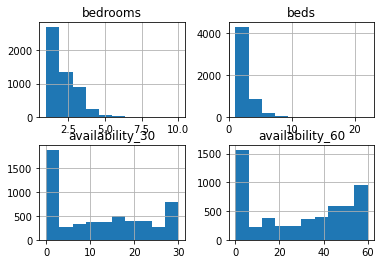

In [21]:
# Constructing some histograms to visualize the distrubution of the variables below
listings_copy[['bedrooms', 'beds', 'availability_30', 'availability_60']].hist()

We see that rentals with 1 bedrooms or having 1 bed are the most common in the Valencia dataset.

In [22]:
# Extracting what type of neighbourhoods are in the city and its count
neighbourhood_counts = listings_copy["neighbourhood_group_cleansed"].value_counts().reset_index()

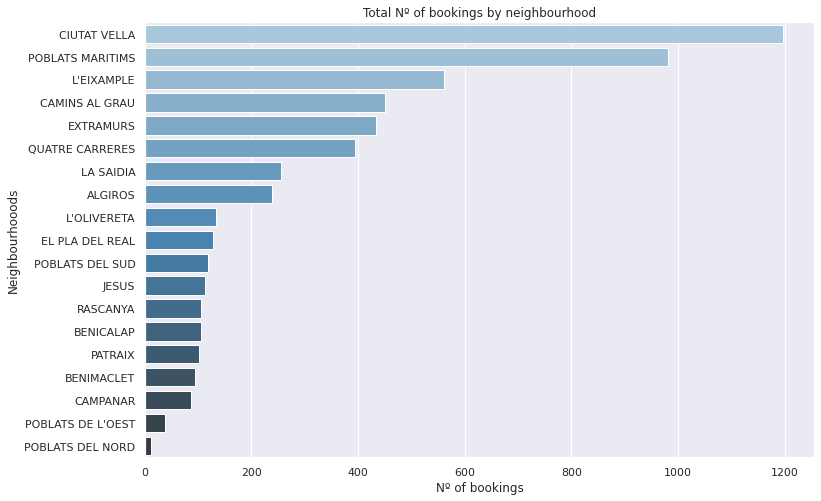

In [23]:
# Representing the total of bookings per neighbourhood
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(12, 8)})
ax = sns.barplot(x= "neighbourhood_group_cleansed", y = "index", data = neighbourhood_counts, palette="Blues_d").set(title='Total Nº of bookings by neighbourhood')
plt.xlabel('Nº of bookings')
plt.ylabel('Neighbourhooods')
plt.show()

Ciutat Vella and Poblats Marítims are the most requested neighbourhoods by the users for this period of time. Moreover, Ciutat Vella has the double of bookings than the other 17 neighbourhoods. Later, this information will be displayed with the coordinates.

Finally, I represented all the rentals in the city for our period of time with the coordinates ('latitude' and 'longitude' variables in the listings dataset). This give us an idea of where they are located on the map.

In [43]:
valencia_locations = list(zip(listings_copy['latitude'], listings_copy['longitude']))

# I centered the map using the coordinates of Valencia
map1 = folium.Map(location = [39.4702, -0.376805], zoom_start = 13)
plugins.FastMarkerCluster(data = valencia_locations).add_to(map1)
map1

# <font color='#A533FF'>Module 3: Data Preparation</font>

### 1. What are the busiest times of the year to rent a room in Valencia? By how much do prices spike?

In order to answer this question, it is needed to extract all the available rents during our data period of time.

To represent availability through time we need the 'available' column of the calendar dataset that is True ('t') and then, plot it with the dates.

Text(0, 0.5, 'Availability rate')

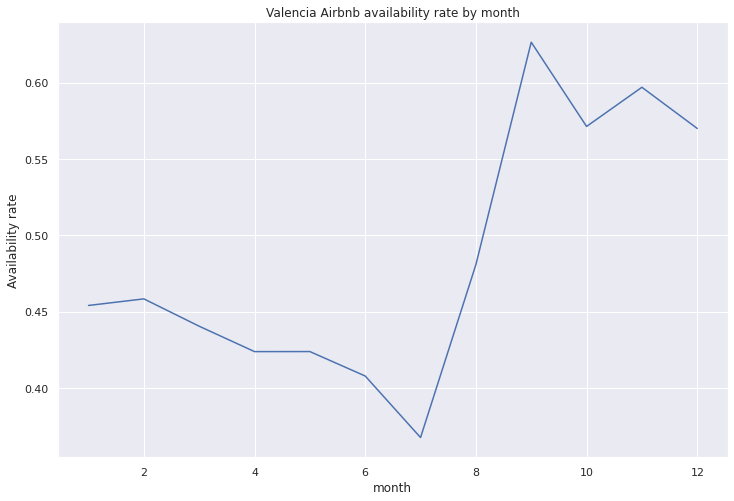

In [25]:
# Selecting only the rows with availability -> True
calendar_copy['available'] = calendar_copy['available'] == 't'

# Extracting the month of the 'date' column
calendar_copy['month'] = pd.DatetimeIndex(calendar_copy['date']).month
ax = calendar_copy.groupby('month')['available'].mean().plot(title = 'Valencia Airbnb availability rate by month')
ax.set_ylabel("Availability rate")

Taking into account that the time period of our data is from 2021-06-27 and 2022-06-28, we observe that the most requested period to book a rental is on July. Also the period between March-June, due to many events that take place in the city (Fallas, Easter season and the beggining of the summer).

It is important taking into account that the extraction of this data was made on 2021-12-18.

Text(0, 0.5, 'Price')

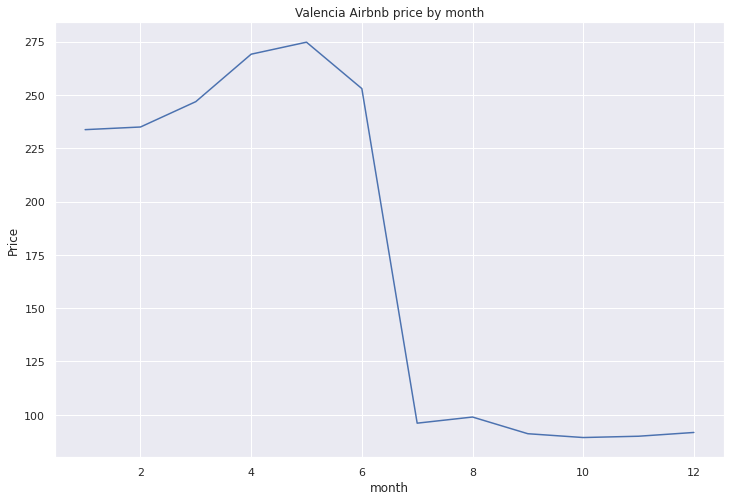

In [26]:
calendar_copy['price'] = calendar_copy['price'].replace('[\$,]', '', regex=True).astype(float)
calendar_copy['month'] = pd.DatetimeIndex(calendar_copy['date']).month

ax = calendar_copy.groupby('month')['price'].mean().plot(title='Valencia Airbnb price by month')
ax.set_ylabel("Price")

In that period of time, we observe that the price raises on March-June (it could be due to the Fallas, the Easter and the beggining of the summer period) between 250-275 €/nigth. Conversely, the lowest prices per night for this dataset are all around 100€ during the summer (July-September) and winter seasons. We observe before that the availability on July is very low, so this will be explained due to the rental price (the lowest).

### 2.  What type of airbnb is the most booked in the city?

In [28]:
# Types of properties and its counts
listings.property_type.value_counts()

Entire rental unit                     2973
Private room in rental unit            1228
Entire loft                             389
Entire condominium (condo)              137
Entire serviced apartment               127
Entire residential home                 108
Private room in residential home        106
Private room in condominium (condo)      71
Private room in bed and breakfast        58
Private room in casa particular          42
Room in boutique hotel                   38
Private room in serviced apartment       36
Entire townhouse                         35
Room in hotel                            31
Private room in hostel                   29
Private room in guest suite              12
Private room in loft                     11
Entire guest suite                        9
Entire vacation home                      8
Shared room in rental unit                8
Entire place                              8
Private room in townhouse                 8
Boat                            

The most frequent property type is an entire rental unit, privates rooms in rental units, entire lofts and also an entire serviced apartment. The less frequent type are shared rooms in farm stays and entire cottages, for example.

Next, it is needed to explore the 'room_type' variable that give us the information about the rental type (house, single room, apartment...).

In [29]:
listings_copy.room_type.value_counts()

Entire home/apt    3829
Private room       1672
Hotel room           24
Shared room          21
Name: room_type, dtype: int64

The most frequent rental type by difference is entire homes or apartments. The less frequent are the shared rooms.

In [30]:
# Merge by 'id' column
calendar_listings = pd.merge(calendar_copy, listings_copy, left_on='listing_id', right_on='id')
calendar_listings.shape

(1521471, 78)

In [31]:
calendar_listings.head()

,listing_id,date,available,price_x,adjusted_price,minimum_nights_x,maximum_nights_x,month,id,listing_url,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,193326,2021-06-28,True,45.0,$45.00,1.0,1125.0,6,193326,https://www.airbnb.com/rooms/193326,...,4.91,4.94,4.74,4.82,f,2,0,2,0,1.56
1,193326,2021-06-29,True,45.0,$45.00,1.0,1125.0,6,193326,https://www.airbnb.com/rooms/193326,...,4.91,4.94,4.74,4.82,f,2,0,2,0,1.56
2,193326,2021-06-30,True,45.0,$45.00,1.0,1125.0,6,193326,https://www.airbnb.com/rooms/193326,...,4.91,4.94,4.74,4.82,f,2,0,2,0,1.56
3,193326,2021-07-01,True,45.0,$45.00,1.0,1125.0,7,193326,https://www.airbnb.com/rooms/193326,...,4.91,4.94,4.74,4.82,f,2,0,2,0,1.56
4,193326,2021-07-02,True,45.0,$45.00,1.0,1125.0,7,193326,https://www.airbnb.com/rooms/193326,...,4.91,4.94,4.74,4.82,f,2,0,2,0,1.56


In [32]:
available_roomtype = calendar_listings.groupby(['available','room_type']).size().reset_index(name='Count')
available_roomtype

,available,room_type,Count
0,False,Entire home/apt,603742
1,False,Hotel room,5315
2,False,Private room,188949
3,False,Shared room,1109
4,True,Entire home/apt,498536
5,True,Hotel room,3080
6,True,Private room,217469
7,True,Shared room,3271


In [33]:
available_roomtype['Percentage'] = [(100 * x/available_roomtype['Count'].sum()).round(2) for x in available_roomtype['Count']]
available_roomtype

,available,room_type,Count,Percentage
0,False,Entire home/apt,603742,39.68
1,False,Hotel room,5315,0.35
2,False,Private room,188949,12.42
3,False,Shared room,1109,0.07
4,True,Entire home/apt,498536,32.77
5,True,Hotel room,3080,0.20
6,True,Private room,217469,14.29
7,True,Shared room,3271,0.21


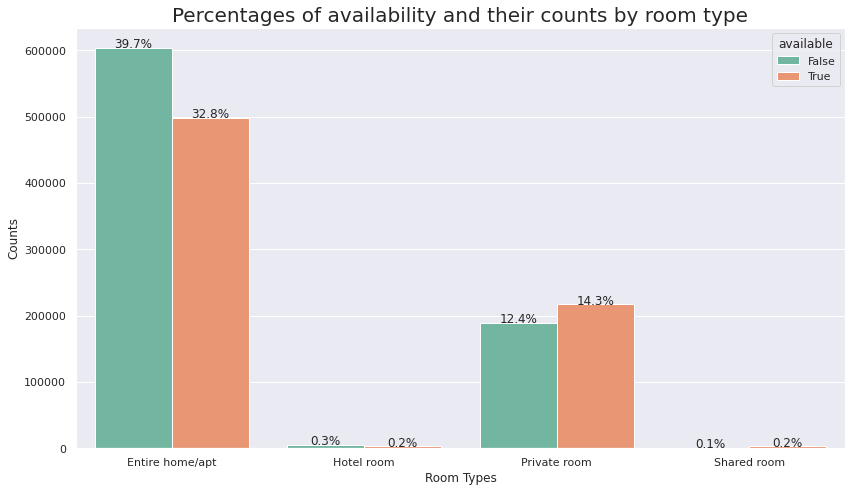

In [34]:
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.autolayout"] = True

percentage = available_roomtype['Percentage']
ax = sns.barplot(x="room_type", y='Count', hue="available", data=available_roomtype, palette='Set2')
patches = ax.patches
ax.set_title("Percentages of availability and their counts by room type" , size = 20)
ax.set_xlabel("Room Types" , size = 12)
ax.set_ylabel("Counts" , size = 12)

for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+.05
    ax.annotate('{:.1f}%'.format(percentage[i]), (x,y), ha='center')
plt.show()

# <font color='#A533FF'>Module 4: Data Modelling</font>

### Question 3. How well can we predict the Airbnb price? What aspects correlate well to the price?

- Observing all the variables in the dataset, I decided to choose the following columns to construct the model:

    'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin', 
    'review_scores_communication', 'review_scores_location','review_scores_value', 'accommodates', 'bedrooms', 
    'beds', 'price','minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 
    'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
    'availability_365', 'number_of_reviews', 'instant_bookable', 'host_is_superhost', 'host_has_profile_pic', 
    'host_identity_verified', 'host_response_rate', 'host_acceptance_rate', 'bathrooms_text'

In [31]:
listings_3 = listings[['review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin',
                       'review_scores_communication', 'review_scores_location','review_scores_value', 'accommodates', 'bedrooms',
                       'beds', 'price','minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
                       'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_365', 'number_of_reviews',
                       'instant_bookable', 'host_is_superhost', 'host_identity_verified', 'host_response_rate',
                       'host_acceptance_rate', 'bathrooms_text']]

print("The listings dataset to construct the model " + str(listings_3.shape[1]) + " columns.")

The listings dataset to construct the model 27 columns.


In [32]:
dummies = pd.get_dummies(listings['room_type'], prefix="room_type", prefix_sep='_',)
listings_3 = pd.concat([listings_3, dummies], axis = 1)
listings_3

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,beds,...,instant_bookable,host_is_superhost,host_identity_verified,host_response_rate,host_acceptance_rate,bathrooms_text,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,4.57,4.66,4.61,4.83,4.72,4.44,4.52,4,2.0,2.0,...,f,f,t,100%,100%,1 bath,1,0,0,0
1,5.00,5.00,5.00,5.00,5.00,5.00,5.00,3,1.0,1.0,...,f,f,t,NaN,NaN,NaN,1,0,0,0
2,4.76,4.73,4.89,4.85,4.75,4.75,4.67,6,3.0,6.0,...,f,f,t,89%,36%,2 baths,1,0,0,0
3,4.62,4.81,4.58,4.86,4.89,4.80,4.65,6,3.0,3.0,...,f,f,t,NaN,78%,2 baths,1,0,0,0
4,4.55,4.47,4.17,4.67,4.61,4.78,4.36,15,5.0,20.0,...,f,f,t,100%,61%,5.5 baths,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1.0,1.0,...,t,f,f,NaN,NaN,1 bath,1,0,0,0
5542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2.0,1.0,...,f,f,f,NaN,NaN,1 bath,1,0,0,0
5543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1.0,2.0,...,t,t,f,100%,100%,1 bath,1,0,0,0
5544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1.0,1.0,...,t,f,f,NaN,NaN,1 bath,1,0,0,0


In [33]:
# Checking the % of data we have available in each column
print(1 - listings_3.isnull().mean())

review_scores_rating           0.868915
review_scores_accuracy         0.864226
review_scores_cleanliness      0.864226
review_scores_checkin          0.864226
review_scores_communication    0.864226
review_scores_location         0.864226
review_scores_value            0.864226
accommodates                   1.000000
bedrooms                       0.946989
beds                           0.978904
price                          1.000000
minimum_nights                 1.000000
maximum_nights                 1.000000
minimum_minimum_nights         1.000000
maximum_minimum_nights         1.000000
minimum_maximum_nights         1.000000
maximum_maximum_nights         1.000000
minimum_nights_avg_ntm         1.000000
maximum_nights_avg_ntm         1.000000
availability_365               1.000000
number_of_reviews              1.000000
instant_bookable               1.000000
host_is_superhost              0.999820
host_identity_verified         0.999820
host_response_rate             0.884962


We observe that the maximum % of NaN in the dataset is around 13% (the first 6 variables related to review scores). Seeing the distribution of the values of this columns (describe function) I decide to imputing this values with the mean of each column.

In [34]:
# Imputing the mean for the first 6 columns of the 'listings_3' subset:
fill_mean = lambda col: col.fillna(col.mean())

try:
    listings_3.iloc[:,0:7].apply(fill_mean, axis=0)
except:
    print('That broke :(')

In [35]:
# Checking the % of values for each column again
print(1 - listings_3.isnull().mean())

review_scores_rating           0.868915
review_scores_accuracy         0.864226
review_scores_cleanliness      0.864226
review_scores_checkin          0.864226
review_scores_communication    0.864226
review_scores_location         0.864226
review_scores_value            0.864226
accommodates                   1.000000
bedrooms                       0.946989
beds                           0.978904
price                          1.000000
minimum_nights                 1.000000
maximum_nights                 1.000000
minimum_minimum_nights         1.000000
maximum_minimum_nights         1.000000
minimum_maximum_nights         1.000000
maximum_maximum_nights         1.000000
minimum_nights_avg_ntm         1.000000
maximum_nights_avg_ntm         1.000000
availability_365               1.000000
number_of_reviews              1.000000
instant_bookable               1.000000
host_is_superhost              0.999820
host_identity_verified         0.999820
host_response_rate             0.884962


For all the other columns with a little % of NaN, I decided to drop them of the dataset.

In [36]:
listings_3 = listings_3.dropna()
# We have all the columns without NaN values
listings_3.isnull().sum()

review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
accommodates                   0
bedrooms                       0
beds                           0
price                          0
minimum_nights                 0
maximum_nights                 0
minimum_minimum_nights         0
maximum_minimum_nights         0
minimum_maximum_nights         0
maximum_maximum_nights         0
minimum_nights_avg_ntm         0
maximum_nights_avg_ntm         0
availability_365               0
number_of_reviews              0
instant_bookable               0
host_is_superhost              0
host_identity_verified         0
host_response_rate             0
host_acceptance_rate           0
bathrooms_text                 0
room_type_Entire home/apt      0
room_type_Hotel room           0
room_type_Private room         0
room_type_

In [37]:
print("The filtered dataset has " + str(listings_3.shape[0]) + " rows and " + str(listings_3.shape[1]) + " columns.")

The filtered dataset has 3971 rows and 31 columns.


Now, it is needed to check the types of the columns and convert them if needed:

In [38]:
listings_3.dtypes

review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
review_scores_value            float64
accommodates                     int64
bedrooms                       float64
beds                           float64
price                           object
minimum_nights                   int64
maximum_nights                   int64
minimum_minimum_nights           int64
maximum_minimum_nights           int64
minimum_maximum_nights           int64
maximum_maximum_nights           int64
minimum_nights_avg_ntm         float64
maximum_nights_avg_ntm         float64
availability_365                 int64
number_of_reviews                int64
instant_bookable                object
host_is_superhost               object
host_identity_verified          object
host_response_rate              object
host_acceptance_rate     

**a)** The variables *'instant_bookable', 'host_is_superhost', 'host_identity_verified'* are boolean, so let's explore more and change the f/t values into 0/1:

In [39]:
listings_3[['instant_bookable', 'host_is_superhost', 'host_identity_verified']] = listings_3[['instant_bookable', 'host_is_superhost', 'host_identity_verified']].replace({"t": 1, "f": 0})

**b)** The 'host_response_rate', 'host_acceptance_rate' and 'price' variables are object type and it is needed to convert them to numeric type:

In [40]:
# Convert to numerical the 'price' variable and drop the dollar and % symbol
listings_3['price'] = listings_3.loc[:,'price'].replace('[\$,]', '', regex=True).astype(float)
listings_3['host_response_rate'] = listings_3.loc[:,'host_response_rate'].replace('[\%,]', '', regex=True).astype(float)
listings_3['host_acceptance_rate'] = listings_3.loc[:,'host_acceptance_rate'].replace('[\%,]', '', regex=True).astype(float)

**c)** Drop text in the 'bathrooms_text' variable:

In [41]:
listings_3['bathrooms_text'] = listings_3.loc[:,'bathrooms_text'].str.split(' ').str[0]
listings_3['bathrooms_text'] = listings_3.loc[:,'bathrooms_text'].replace('Half-bath', 0.5, regex=True).astype(float)
# Visualize different number of bathrooms and checking anomalies
listings_3['bathrooms_text'].value_counts()

1.0    2520
2.0     822
1.5     472
2.5      69
3.0      50
0.0      11
3.5       9
4.0       7
5.0       4
4.5       2
0.5       2
5.5       1
7.0       1
6.5       1
Name: bathrooms_text, dtype: int64

<AxesSubplot:>

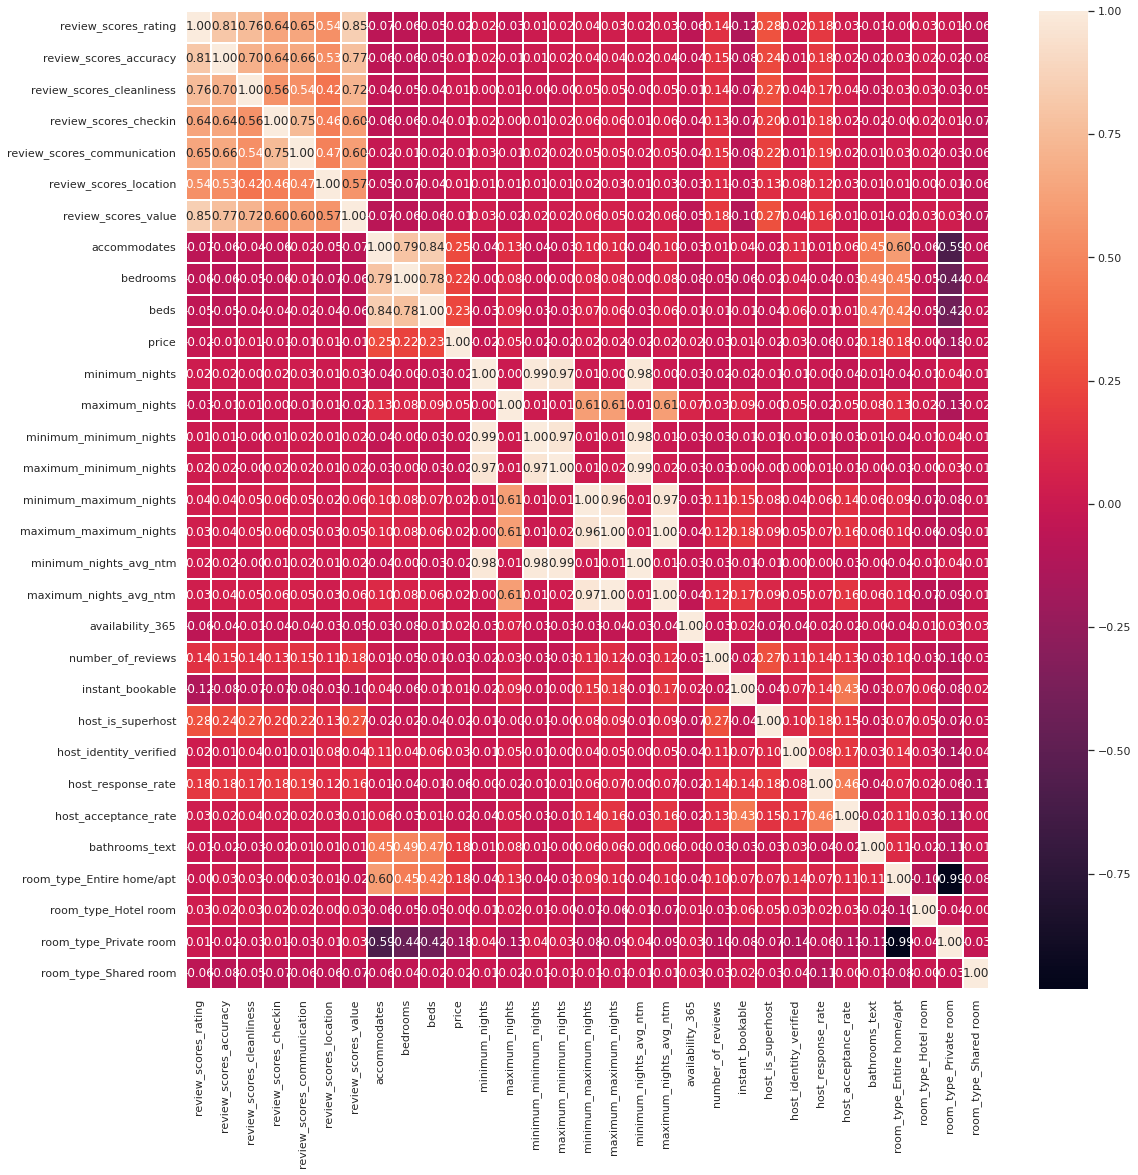

In [42]:
# Print a heatmap with the variable correlations
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(listings_3.corr(), annot = True, linewidths=.3, fmt = ".2f", ax= ax)

In order to understand how well our linear model (lm_model) fit the dataset, we first needed to split our data into train and test data sets (X_train and y_train).  

In [43]:
X = listings_3[['number_of_reviews', 'availability_365', 'accommodates', 'bedrooms', 'host_identity_verified',
                'instant_bookable', 'beds', 'availability_365', 'number_of_reviews', 'host_acceptance_rate', 
                'host_identity_verified', 'bathrooms_text', 'room_type_Entire home/apt', 'room_type_Hotel room',
                'room_type_Private room', 'room_type_Shared room']]

y = listings_3['price']

In [44]:
# Split into train (70%) and test(30%) with a setseed of 42 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

# Instantiate a linear model
lm_model = LinearRegression(normalize=True) 

# Fitting the model to our data
lm_model.fit(X_train, y_train)

LinearRegression(normalize=True)

In [45]:
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
print("The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test)))

The r-squared score for the model using only quantitative variables was 0.2914561136691658 on 1192 values.


## Random Forest Regressor

**a)** Same variables but different model:

In [46]:
# Split the data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.25, random_state = 2090)

In [47]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 2090)

# Train the model on training data
rf.fit(train_X, train_y);

In [48]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_X)

# Calculate the absolute errors
errors = abs(predictions - test_y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 27.19 degrees.


In [49]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_y)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 62.23 %.


**b)** Adding more variables to the model:

In [50]:
X = listings_3[['review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin',
                'review_scores_communication', 'review_scores_location','review_scores_value', 'accommodates', 'bedrooms',
                'beds', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
                'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_365', 'number_of_reviews',
                'instant_bookable', 'host_is_superhost', 'host_identity_verified', 'host_response_rate',
                'host_acceptance_rate', 'bathrooms_text', 'room_type_Entire home/apt', 'room_type_Hotel room',
                'room_type_Private room', 'room_type_Shared room']]

y = listings_3['price']

In [51]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.25, random_state = 2090)

rf = RandomForestRegressor(n_estimators = 1000, random_state = 2090)
rf.fit(train_X, train_y);

predictions = rf.predict(test_X)
errors = abs(predictions - test_y)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

mape = 100 * (errors / test_y)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 26.33 degrees.
Accuracy: 63.4 %.


# <font color='#A533FF'>Module 5: Result Evaluation</font>

# <font color='#A533FF'>Module 6: Deployment </font>

This section is available on the following sites:

[...]